# Stage 1 - Capacity Prediction with only L input

All Code used in HPC

In [2]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Initialize scalars outside the dataset class
length_scaler = StandardScaler()
cptu_scaler = StandardScaler()
output_scaler = StandardScaler()




class BoreholeDataset(Dataset):
    def __init__(self, csv_file, length_scaler, cptu_scaler, output_scaler, fit_scalers=True):
        # Load the data
        data = pd.read_csv(csv_file)

        # Extracting Length, CPTu, and Output columns
        self.lengths = data.iloc[:, 0].values.reshape(-1, 1)
        self.cptu_data = data.iloc[:, 1:6163].values
        self.outputs = data.iloc[:, 6163].values.reshape(-1, 1)

        # Scale the data if required
        if fit_scalers:
            self.lengths = length_scaler.fit_transform(self.lengths)
            self.cptu_data = cptu_scaler.fit_transform(self.cptu_data)
            self.outputs = output_scaler.fit_transform(self.outputs)
        else:
            self.lengths = length_scaler.transform(self.lengths)
            self.cptu_data = cptu_scaler.transform(self.cptu_data)
            self.outputs = output_scaler.transform(self.outputs)

        # Convert numpy arrays to tensors
        self.lengths = torch.tensor(self.lengths, dtype=torch.float32)
        self.cptu_data = torch.tensor(self.cptu_data, dtype=torch.float32)
        self.outputs = torch.tensor(self.outputs, dtype=torch.float32)

    def __len__(self):
        return len(self.outputs)

    def __getitem__(self, idx):
        # Returning tensors that will be automatically sent to the device during the batch gathering by the DataLoader
        return self.lengths[idx], self.cptu_data[idx], self.outputs[idx]


# Prepare datasets and loaders
train_dataset = BoreholeDataset('Stage_1_traind_merged_reduced.csv', length_scaler, cptu_scaler, output_scaler,
                                fit_scalers=True)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = BoreholeDataset('Stage_1_vald_merged_reduced.csv', length_scaler, cptu_scaler, output_scaler,
                              fit_scalers=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

import torch
import torch.nn as nn
import torch.nn.functional as F


class TwoBranchMLP(nn.Module):
    def __init__(self, cptu_input_features, length_input_features, neurons, layers, dropout_rate=0.3):
        super(TwoBranchMLP, self).__init__()

        # Initialize branches with different input feature sizes
        self.cptu_branch = self.create_branch(cptu_input_features, neurons, layers, dropout_rate)
        self.length_branch = self.create_branch(length_input_features, neurons, layers, dropout_rate)

        # Output layer
        self.combined = nn.Sequential(
            nn.Linear(2 * neurons, neurons),  # Combining outputs from two branches
            nn.Tanh(),
            nn.Linear(neurons, 1)
        )

    def create_branch(self, input_features, neurons, layers, dropout_rate):
        """Creates a branch with a specified number of layers and different input sizes."""
        modules = []
        current_input_features = input_features
        for _ in range(layers):
            modules.append(nn.Linear(current_input_features, neurons))
            modules.append(nn.Tanh())
            modules.append(nn.BatchNorm1d(neurons))
            modules.append(nn.Dropout(dropout_rate))
            current_input_features = neurons  # Set the next layer's input size to the fixed neuron count
        return nn.Sequential(*modules)

    def forward(self, cptu_data, length_data):
        cptu_out = self.cptu_branch(cptu_data)
        length_out = self.length_branch(length_data)
        combined_in = torch.cat((cptu_out, length_out), dim=1)
        output = self.combined(combined_in)
        return output


def initialize_weights(m):
    if isinstance(m, nn.Linear):
        init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
        if m.bias is not None:
            init.constant_(m.bias, 0)


model = TwoBranchMLP(6162, 1, 14, 3, 0)

model.apply(initialize_weights)

from torch.optim.lr_scheduler import ReduceLROnPlateau

# Initialize your optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

import torch

from torch.optim.lr_scheduler import ReduceLROnPlateau


def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20)
    model.train()
    loss_history = []
    val_loss_history = []
    learning_rate_history = []  # To track learning rates over epochs

    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (length_data, cptu_data, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(cptu_data, length_data)
            loss = criterion(outputs, targets.view_as(outputs))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        average_train_loss = running_loss / len(train_loader)
        loss_history.append(average_train_loss)

        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for length_data, cptu_data, targets in val_loader:
                outputs = model(cptu_data, length_data)
                loss = criterion(outputs, targets.view_as(outputs))
                val_loss += loss.item()

        average_val_loss = val_loss / len(val_loader)
        val_loss_history.append(average_val_loss)

        scheduler.step(average_val_loss)

        # Track current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        learning_rate_history.append(current_lr)

        model.train()  # Switch back to train mode after validation

    return loss_history, val_loss_history, learning_rate_history


loss_history1 = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=1)
print(loss_history1)

# torch.save(model.state_dict(), "S1_1_model1.pth")
# 
# with open('S1_1_loss1.txt', 'w') as file:
#     for item in loss_history1:
#         file.write(f"{item}\n")
# 
# from joblib import dump
# dump((length_scaler, cptu_scaler, output_scaler), 'S1_1_scalers1.joblib')

([4.582918225657979], [8.234026370377377], [0.001])


## Stage 1 - Evaluating HPC Imported Loss Values

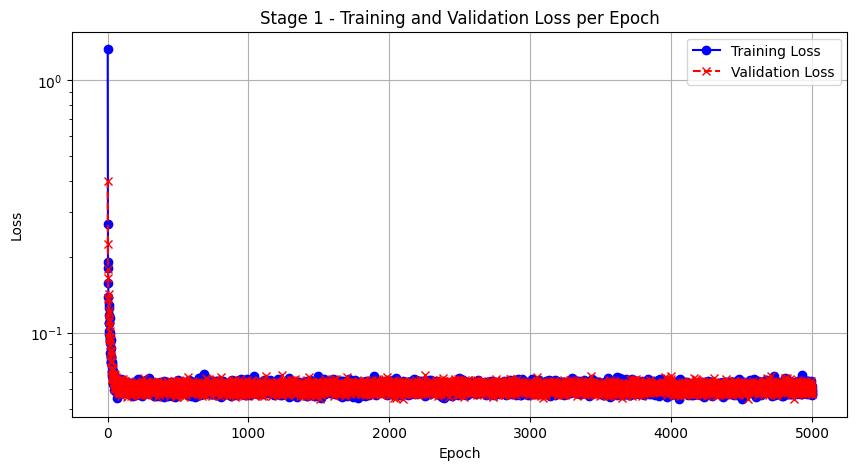

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Path to the text file
file_path = 'S1_loss21.txt'

# Read the entire file into a single string
with open(file_path, 'r') as file:
    line = file.readline().strip()

# Remove the brackets and split the string into a list of numbers
cleaned_line = line.strip('[]')
numbers = list(map(float, cleaned_line.split(',')))

# Assuming alternate entries for training and validation losses
train_losses = numbers[0::2]  # Extract even index elements: training losses
val_losses = numbers[1::2]  # Extract odd index elements: validation losses

# Epochs array based on the shorter of the two lists
epochs = np.arange(1, min(len(train_losses), len(val_losses)) + 1)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, marker='o', linestyle='-', color='blue', label='Training Loss')
plt.plot(epochs, val_losses, marker='x', linestyle='--', color='red', label='Validation Loss')
plt.title('Stage 1 - Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()


## Stage 1 - Calculating and Plotting Relative Error

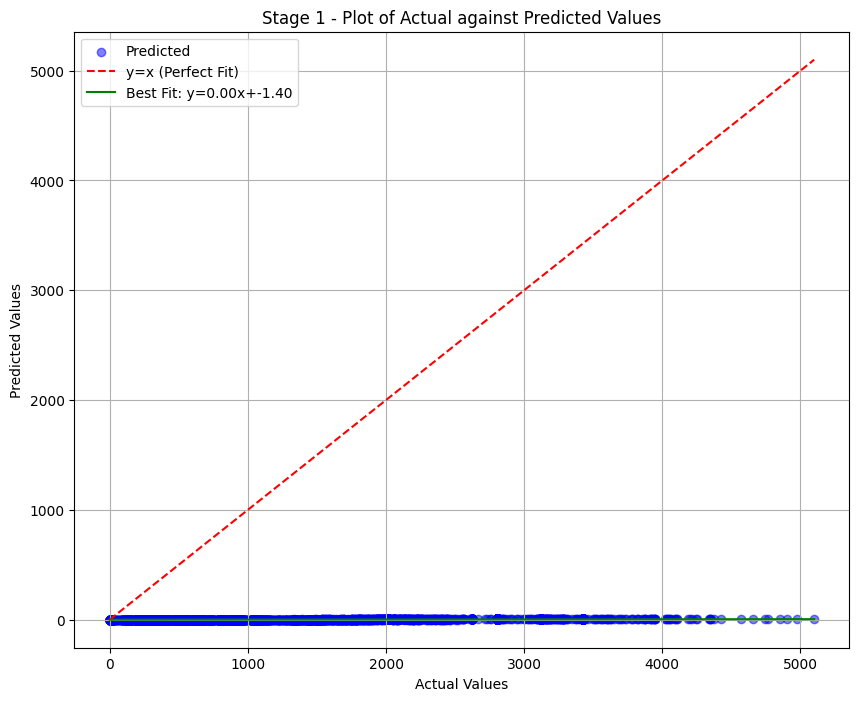

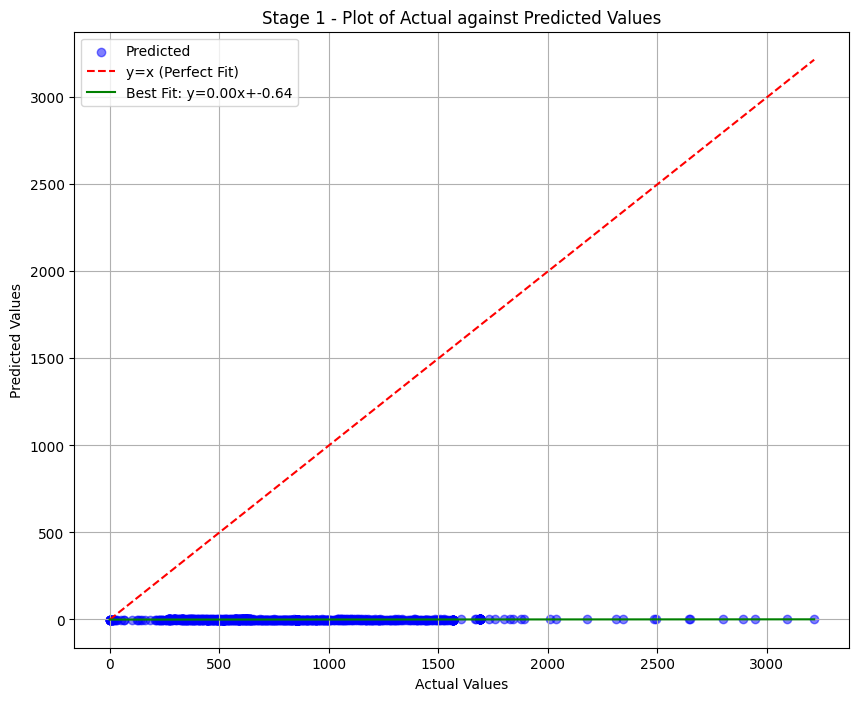

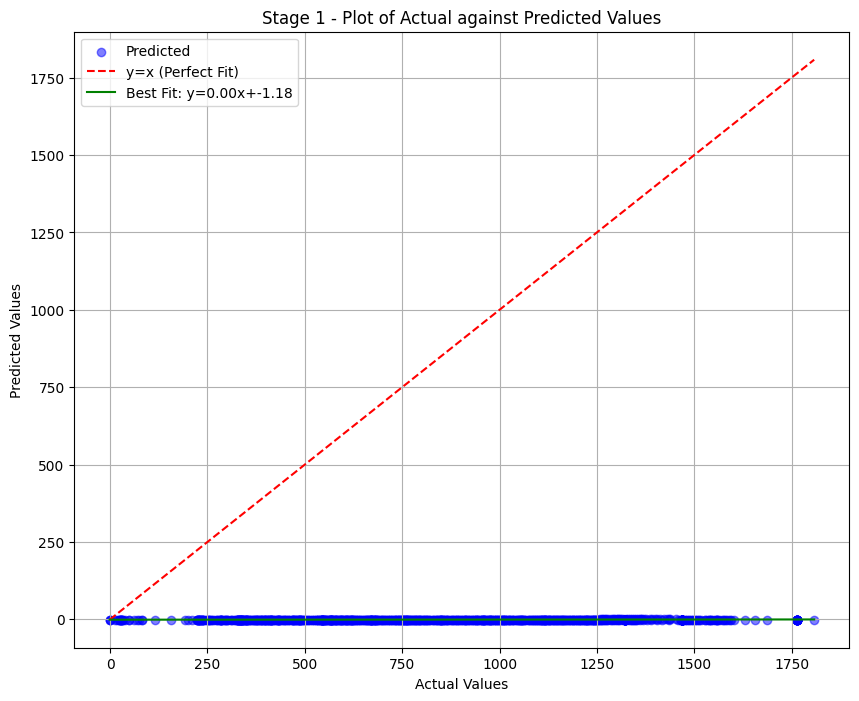

Training MSE: 44381.9200, R²: 0.9575, Relative Error: 51.3320
Validation MSE: 895998.5326, R²: -3.2068, Relative Error: 52257.8857
Testing MSE: 130163.3077, R²: 0.2584, Relative Error: 250.1865


In [3]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score, mean_squared_error
from joblib import load

# Load model and scalers
# model = YourModelClass()  # Ensure to define your model class correctly
model.load_state_dict(torch.load('S1_model21.pth'))
model.eval()

length_scaler, cptu_scaler, output_scaler = load('S1_scalers21.joblib')

def process_data(csv_file, length_scaler, cptu_scaler, output_scaler):
    data = pd.read_csv(csv_file)
    inputs = torch.tensor(length_scaler.transform(data.iloc[:, 0].values.reshape(-1, 1)), dtype=torch.float32)
    CPTu = torch.tensor(cptu_scaler.transform(data.iloc[:, 1:6163].values), dtype=torch.float32)
    targets = torch.tensor(output_scaler.transform(data.iloc[:, 6163].values.reshape(-1, 1)), dtype=torch.float32)
    return DataLoader(TensorDataset(inputs, CPTu, targets), batch_size=64, shuffle=False)

# Load your datasets
train_loader = process_data('Stage_1_traind_merged_reduced.csv', length_scaler, cptu_scaler, output_scaler)
val_loader = process_data('Stage_1_vald_merged_reduced.csv', length_scaler, cptu_scaler, output_scaler)
test_loader = process_data('Stage_1_testd_merged_reduced.csv', length_scaler, cptu_scaler, output_scaler)



def plot_actual_vs_predicted(filename, actuals, predictions, title='Actual vs. Predicted', actual_scaler=None, prediction_scaler=None):
    # If scalers are provided, inverse transform the data
    if actual_scaler is not None:
        actuals = actual_scaler.inverse_transform(actuals.reshape(-1, 1)).flatten()
    if prediction_scaler is not None:
        predictions = prediction_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

    # Flatten arrays to ensure they are 1D
    actuals = actuals.flatten()
    predictions = predictions.flatten()

    # Create a scatter plot of actual vs predicted values
    plt.figure(figsize=(10, 8))
    plt.scatter(actuals, predictions, alpha=0.5, color='blue', label='Predicted')

    # Plot the identity line
    max_val = max(max(actuals), max(predictions))
    min_val = min(min(actuals), min(predictions))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y=x (Perfect Fit)')

    # Calculate the line of best fit
    coefficients = np.polyfit(actuals, predictions, 1)
    polynomial = np.poly1d(coefficients)
    trendline = polynomial(np.linspace(min_val, max_val, 100))
    plt.plot(np.linspace(min_val, max_val, 100), trendline, 'g-', label=f'Best Fit: y={coefficients[0]:.2f}x+{coefficients[1]:.2f}')

    # Add labels and legend
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Stage 1 - Plot of Actual against Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{filename}.png', dpi=300)
    plt.show()
    
    

def evaluate_model(file_name, data_loader, output_scaler):
    total_mse = 0
    total_samples = 0
    preds, actuals = [], []
    relative_errors = []

    with torch.no_grad():
        for inputs, CPTu, targets in data_loader:
            outputs = model( CPTu, inputs)

            # Inverse transform the outputs and targets for MSE calculation only
            outputs_rescaled = output_scaler.inverse_transform(outputs.numpy())
            targets_rescaled = output_scaler.inverse_transform(targets.numpy())

            # Compute MSE on rescaled data
            mse = mean_squared_error(targets_rescaled, outputs_rescaled)
            total_mse += mse * inputs.size(0)
            total_samples += inputs.size(0)

            preds.append(outputs)
            actuals.append(targets)

            # Compute relative error on scaled data
            relative_error = np.abs((targets.numpy() - outputs.numpy()) / targets.numpy())
            valid_relative_error = relative_error[~np.isinf(relative_error)]
            relative_errors.extend(valid_relative_error)

    all_preds = torch.cat(preds).numpy()
    all_actuals = torch.cat(actuals).numpy()
    
    plot_actual_vs_predicted(file_name, all_actuals, all_preds, output_scaler, output_scaler)
    
    # Calculate total MSE
    total_mse /= total_samples
    
    # Calculate R² score on scaled data
    r2 = r2_score(all_actuals, all_preds)

    # Calculate mean relative error on scaled data
    mean_relative_error = np.mean(relative_errors) if len(relative_errors) > 0 else np.inf

    return total_mse, r2, mean_relative_error

# Evaluate the model using separate scaling for MSE
train_mse, train_r2, train_rel_error = evaluate_model('S1_training_data_plot', train_loader, output_scaler)
val_mse, val_r2, val_rel_error = evaluate_model('S1_validating_data_plot', val_loader, output_scaler)
test_mse, test_r2, test_rel_error = evaluate_model('S1_testing_data_plot', test_loader, output_scaler)

print(f"Training MSE: {train_mse:.4f}, R²: {train_r2:.4f}, Relative Error: {train_rel_error*100:.4f}")
print(f"Validation MSE: {val_mse:.4f}, R²: {val_r2:.4f}, Relative Error: {val_rel_error*100:.4f}")
print(f"Testing MSE: {test_mse:.4f}, R²: {test_r2:.4f}, Relative Error: {test_rel_error*100:.4f}")


# To access the final model weights after evaluation:
final_weights = model.state_dict()  # This dictionary holds all weights
# You can save these weights or print t


## Stage 1 - Plotting Stage 1 Test Data Results

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the CSV file with low_memory=False to handle mixed types better
df = pd.read_csv('Stage_1_traind_merged_reduced.csv', header=None, low_memory=False)
# df = pd.read_csv('Stage_1_vald_merged_reduced.csv', header=None, low_memory=False)
# df = pd.read_csv('Stage_1_testd_merged_reduced.csv', header=None, low_memory=False)

# Convert columns to numeric, coercing errors to NaN (which won't be plotted)
df = df.apply(pd.to_numeric, errors='coerce')

print(len(df))

import matplotlib.pyplot as plt

# Define the number of sets
num_sets = (len(df) - 1) // 309  # Assuming this formula to calculate the number of sets
print(num_sets)

# Colors for the plots
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
colors = colors[:num_sets]  # Ensure the color list matches the number of sets

df['Set'] = np.arange(len(df)) % num_sets

# Plot each set
for set_index in range(num_sets):
    set_df = df[df['Set'] == set_index]
    plt.plot(  set_df.iloc[:, 0],set_df.iloc[:, 6163],  color=colors[set_index], label=f'Set {set_index + 1}')



# Handling labels and legends intelligently to avoid duplicate labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
# plt.gca().invert_yaxis()

# plt.gca().xaxis.tick_top()
# plt.gca().xaxis.set_label_position('top') 

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.ylabel('Pile Length (m)')
plt.xlabel('Pile Bearing Capacity (kN)')
plt.title('Stage 1 - Pile Length (m) vs Bearing Capacity (RBC) - Fixed Diameter = 0.4 metres')
plt.show()


## PLotting Validation and Testing Errors

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the CSV files
df_test = pd.read_csv('Stage_1_testd_merged_reduced.csv', header=None, low_memory=False)
df_val = pd.read_csv('Stage_1_vald_merged_reduced.csv', header=None, low_memory=False)

# Convert columns to numeric, coercing errors to NaN
df_test = df_test.apply(pd.to_numeric, errors='coerce')
df_val = df_val.apply(pd.to_numeric, errors='coerce')

# Assuming each file has similar structure and processing needs
def process_data(df):
    num_sets = (len(df) - 1) // 309  # Update the calculation if needed
    df['Set'] = np.arange(len(df)) % num_sets
    return df, num_sets

df_train, num_sets_test = process_data(df_test)
df_val, num_sets_val = process_data(df_val)

# Colors for the plots
colors_test = ['red', 'red', 'red']
colors_val = ['green', 'green', 'green']

# Plot each set from training data
for set_index in range(num_sets_test):
    set_df = df_test[df_test['Set'] == set_index]
    plt.plot(set_df.iloc[:, 0], set_df.iloc[:, 6163], color=colors_test[set_index % len(colors_test)], label=f'Test Set {set_index + 1}')

# Plot each set from validation data
for set_index in range(num_sets_val):
    set_df = df_val[df_val['Set'] == set_index]
    plt.plot(set_df.iloc[:, 0], set_df.iloc[:, 6163], color=colors_val[set_index % len(colors_val)], label=f'Val Set {set_index + 1}')

# Handling labels and legends intelligently to avoid duplicate labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.legend(loc='upper left')
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.grid(True)
plt.ylabel('Pile Length Optimised for Minimum Volume')
plt.xlabel('Pile Bearing Capacity (kN)')
plt.title('Optimised Pile Length (m) vs Required Bearing Capacity (RBC)')
plt.savefig('Plot of Stage 1 - Validation and Testing Data - Pile Length vs Bearing Capacity', dpi=300)

plt.show()


In [ ]:
## Attempting to create a visaulisation of code

In [ ]:
# import visualkeras
# 
# model = TwoBranchMLP(7, 1, 18, 3, 0)
# 
# visualkeras.layered_view(model).show() # display using your system viewer
# visualkeras.layered_view(model, to_file='S1_Model_Architecture.png') # write to disk
# visualkeras.layered_view(model, to_file='S1_Model_Architecture.png').show() # write and show
# 
# visualkeras.layered_view(model)

## Old Code - Calculating Correlation Coefficient for Training, Validating and Testing Data

In [ ]:
# from joblib import load
# import pandas as pd
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# 
# # Loading scalers from a joblib file
# length_scaler_e, cptu_scaler_e, output_scaler_e = load('S1_scalers7.joblib')
# 
# # Load the model and device setup
# model.load_state_dict(torch.load('S1_model7.pth'))
# model.eval()
# 
# # Function to process data
# def process_data(data):
#     sets = {}
#     for i in range(len(data) // 309):
#         set_data = data.iloc[i::3, :]
#         lengths = set_data.iloc[:, 0].values.reshape(-1, 1)
#         cptu_data = set_data.iloc[:, 1:6163].values
#         outputs = set_data.iloc[:, 6163].values.reshape(-1, 1)
# 
#         # Apply scalers
#         sets[f"set{i+1}"] = {
#             "lengths": torch.tensor(length_scaler_e.transform(lengths), dtype=torch.float32),
#             "cptu": torch.tensor(cptu_scaler_e.transform(cptu_data), dtype=torch.float32),
#             "outputs": torch.tensor(output_scaler_e.transform(outputs), dtype=torch.float32)
#         }
#     return sets
# 
# # Load your data
# train_data = pd.read_csv('Stage_1_traind_merged_reduced.csv')
# val_data = pd.read_csv('Stage_1_vald_merged_reduced.csv')
# test_data = pd.read_csv('Stage_1_testd_merged_reduced.csv')
# 
# def evaluate_model(model, lengths_tensor, cptu_tensor, outputs_tensor):
#     model.eval()
#     with torch.no_grad():
#         predictions = model( cptu_tensor, lengths_tensor)
#         loss = torch.nn.functional.mse_loss(predictions, outputs_tensor).item()
#     return predictions.numpy(), outputs_tensor.numpy(), loss
# 
# 
# 
# # Process all datasets
# train_sets = process_data(train_data)
# val_sets = process_data(val_data)
# test_sets = process_data(test_data)
# 
# All_R2 = []
# 
# # Define a function to evaluate and plot results
# def evaluate_and_plot(sets, title):
#     results = {}
#     for i in range(1, len(sets) +1):
#         key = f"set{i}"
#         
#         pred, actuals, loss = evaluate_model(
#             model, 
#             sets[key]["lengths"], 
#             sets[key]["cptu"], 
#             sets[key]["outputs"]
#         )
#         results[key] = {
#             "predictions": output_scaler_e.inverse_transform(pred.reshape(-1, 1)),
#             "actuals": output_scaler_e.inverse_transform(actuals.reshape(-1, 1)),
#             "loss": loss
#         }
# 
#     # Plotting each set
#     for i, key in enumerate(results.keys()):
#         actuals = results[key]['actuals']
#         predictions = results[key]['predictions']
#        
#         # plt.figure(figsize=(10, 6))
#         # # Plot actual values
#         # plt.scatter(sets[key]["lengths"].numpy(), actuals, color='green', alpha=0.5, label='Actual Values')
#         # # Plot predicted values
#         # plt.scatter(sets[key]["lengths"].numpy(), predictions, color='red', alpha=0.5, label='Predicted Values')
#         # 
#         # plt.title(f'{title} - Actual vs Predicted Bearing Capacity')
#         # plt.xlabel('Pile Length (m)')
#         # plt.ylabel('Pile Bearing Capacity (kN)')
#         # plt.legend()
#         # plt.grid(True)
#         # plt.show()
# 
#         # Calculation of R²
#         actuals = np.array(actuals, dtype=np.float32)
#         predictions = np.array(predictions, dtype=np.float32)
#         ss_res = np.sum((actuals - predictions) ** 2)
#         ss_tot = np.sum((actuals - np.mean(actuals)) ** 2)
#         r2_value = 1 - ss_res / ss_tot
#         # print(f'R² value for {title}: {r2_value:.4f}')
#         All_R2.append(r2_value)
#         
# # Evaluate and plot for each dataset
# evaluate_and_plot(train_sets, "Training Data")
# evaluate_and_plot(val_sets, "Validation Data")
# evaluate_and_plot(test_sets, "Testing Data")
# 
# 
# ## Splitting up R2 values
# Train_R2 = All_R2[:16]   # First 16 values
# Val_R2 = All_R2[16:19] # Next 3 values
# Test_R2 = All_R2[19:]    # Last 3 values
# 
# ## Plotting graph of r2 values
# Train_Bh_no = np.arange(0, 16, 1)
# Val_Bh_no = np.arange(0, 3, 1)
# Test_Bh_no = np.arange(0, 3, 1)
# 
# print('Training set mean R2 = ', np.mean(Train_R2))
# print('Validaing set mean R2 = ', np.mean(Val_R2))
# print('Testing set mean R2 = ', np.mean(Test_R2))
# 
# datasets = [
#     (Train_R2, Train_Bh_no, 'Training Set R² Values', 'blue'),
#     (Val_R2, Val_Bh_no, 'Validation Set R² Values', 'green'),
#     (Test_R2, Test_Bh_no, 'Testing Set R² Values', 'red')
# ]
# 
# # Loop through the datasets and plot each
# for data, bh_no, title, color in datasets:
#     plt.figure(figsize=(10, 6))
#     plt.plot(bh_no, data, marker='o', linestyle='-', color=color)  # 'o' for circle markers
#     plt.title(title)
#     plt.xlabel('Borehole Number')
#     plt.ylabel('R² Value')
#     plt.ylim(bottom=-1, top=1)
#     plt.grid(True)
#     plt.show()

In [ ]:
# from joblib import load
# import pandas as pd
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# 
# # Load scalers from a joblib file
# length_scaler_e, cptu_scaler_e, output_scaler_e = load('S1_scalers6.joblib')
# 
# # Load the model and device setup
# model.load_state_dict(torch.load('S1_model6.pth'))
# model.eval()
# 
# # Function to process each data file
# def process_data(data, num_sets):
#     sets = {}
#     num_rows = len(data) // num_sets  # Calculate how many rows each set should have
#     for i in range(num_sets):
#         start_index = i * num_rows
#         end_index = (i + 1) * num_rows if i < num_sets - 1 else len(data)
#         set_data = data.iloc[start_index:end_index]
#         lengths = set_data.iloc[:, 0].values.reshape(-1, 1)
#         cptu_data = set_data.iloc[:, 1:6163].values
#         outputs = set_data.iloc[:, 6163].values.reshape(-1, 1)
# 
#         # Apply scalers
#         sets[f"set{i+1}"] = {
#             "lengths": torch.tensor(length_scaler_e.transform(lengths), dtype=torch.float32),
#             "cptu": torch.tensor(cptu_scaler_e.transform(cptu_data), dtype=torch.float32),
#             "outputs": torch.tensor(output_scaler_e.transform(outputs), dtype=torch.float32)
#         }
#     return sets
# 
# # Load data
# train_data = pd.read_csv('Stage_1_traind_merged_reduced.csv')
# val_data = pd.read_csv('Stage_1_vald_merged_reduced.csv')
# test_data = pd.read_csv('Stage_1_testd_merged_reduced.csv')
# 
# # Assuming we divide each dataset into 3 sets as an example
# train_sets = process_data(train_data, 3)
# val_sets = process_data(val_data, 3)
# test_sets = process_data(test_data, 3)
# 
# # Function to evaluate and plot results
# def evaluate_and_plot(sets, title):
#     for i, key in enumerate(sets):
#         pred, actuals, loss = evaluate_model(
#             model, 
#             sets[key]["lengths"], 
#             sets[key]["cptu"], 
#             sets[key]["outputs"]
#         )
# 
#         plt.figure(figsize=(10, 6))
#         actuals = output_scaler_e.inverse_transform(actuals.reshape(-1, 1))
#         predictions = output_scaler_e.inverse_transform(pred.reshape(-1, 1))
# 
#         # Plot actual values
#         plt.scatter(sets[key]["lengths"].numpy(), actuals, color='green', alpha=0.5, label='Actual Values')
#         # Plot predicted values
#         plt.scatter(sets[key]["lengths"].numpy(), predictions, color='red', alpha=0.5, label='Predicted Values')
# 
#         plt.title(f'{title} - Set {i+1} - Actual vs Predicted Bearing Capacity')
#         plt.xlabel('Pile Length (m)')
#         plt.ylabel('Pile Bearing Capacity (kN)')
#         plt.legend()
#         plt.grid(True)
#         plt.show()
# 
#         actuals = np.array(actuals, dtype=np.float32)
#         predictions = np.array(predictions, dtype=np.float32)
#         ss_res = np.sum((actuals - predictions) ** 2)
#         ss_tot = np.sum((actuals - np.mean(actuals)) ** 2)
#         r2_value = 1 - ss_res / ss_tot
#         print(f'R² value for {title} Set {i+1}: {r2_value:.4f}')
# 
# # Evaluate and plot for each dataset
# evaluate_and_plot(train_sets, "Training Data")
# evaluate_and_plot(val_sets, "Validation Data")
# evaluate_and_plot(test_sets, "Testing Data")


## Old Code

In [ ]:
# import torch
# import torch.nn.functional as F
# from torch.utils.data import DataLoader
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np
# import torch
# from joblib import load
# 
# # Load the model and device setup
# model.load_state_dict(torch.load('S1_model4.pth'))
# model.eval()
# 
# 
# # Load validation and testing data with proper scaler usage
# num_rows = len(pd.read_csv('Stage_1_traind_merged_reduced.csv'))
# 
# train_dataset_e = BoreholeDataset('Stage_1_traind_merged_reduced.csv', length_scaler, cptu_scaler, output_scaler, fit_scalers=False)
# train_loader_e = DataLoader(train_dataset_e, batch_size=num_rows, shuffle=False)
# 
# val_dataset_e = BoreholeDataset('Stage_1_vald_merged_reduced.csv', length_scaler, cptu_scaler, output_scaler, fit_scalers=False)
# val_loader_e = DataLoader(val_dataset_e, batch_size=num_rows, shuffle=False)
# 
# test_dataset_e = BoreholeDataset('Stage_1_testd_merged_reduced.csv', length_scaler, cptu_scaler, output_scaler, fit_scalers=False)
# test_loader_e = DataLoader(test_dataset_e, batch_size=num_rows, shuffle=False)
# 
# 
# 
# #Extracting Scalers from Model
# length_scaler_e, cptu_scaler_e, output_scaler_e = load('S1_scalers.joblib')
# 
# print(length_scaler_e, cptu_scaler_e, output_scaler_e)
# 
# 
# import matplotlib.pyplot as plt
# import torch
# import torch.nn.functional as F
# import numpy as np
# 
# def evaluate_model(model, loader, length_scaler_e, cptu_scaler_e, output_scaler_e):
#     model.eval()
#     predictions = {f'Borehole {i+1}': [] for i in range(3)}
#     targets = {f'Borehole {i+1}': [] for i in range(3)}
#     
#     with torch.no_grad():
#         for lengths, cptu_data, outputs in loader:
#             # Scale the inputs
#             lengths_scaled = torch.tensor(length_scaler_e.transform(lengths.numpy()))
#             cptu_data_scaled = torch.tensor(cptu_scaler_e.transform(cptu_data.numpy()))
#             
#             # Scale the outputs for comparison after prediction
#             outputs_scaled = torch.tensor(output_scaler_e.transform(outputs.numpy()))
#             
#             predicted_outputs_scaled = model(cptu_data_scaled, lengths_scaled)
#             
#             for i in range(len(outputs)):
#                 borehole_id = (i % 3) + 1  # Calculate borehole ID based on index
#                 predictions[f'Borehole {borehole_id}'].append(predicted_outputs_scaled[i])
#                 targets[f'Borehole {borehole_id}'].append(outputs_scaled[i])
# 
#     metrics = {}
#     all_preds = []
#     all_targets = []
#     for i in range(3):
#         bh_id = f'Borehole {i+1}'
#         pred_tensor_scaled = torch.stack(predictions[bh_id])
#         target_tensor_scaled = torch.stack(targets[bh_id])
#         pred_tensor_np_scaled = pred_tensor_scaled.numpy()
#         target_tensor_np_scaled = target_tensor_scaled.numpy()
#         
#         # Collect all predictions and actuals for plotting
#         all_preds.extend(pred_tensor_np_scaled.flatten())
#         all_targets.extend(target_tensor_np_scaled.flatten())
# 
#         ase_scaled = F.mse_loss(pred_tensor_scaled, target_tensor_scaled).item()
#         rmse_scaled = np.sqrt(ase_scaled)
#         mare_scaled = np.mean(np.abs((target_tensor_np_scaled - pred_tensor_np_scaled) / (target_tensor_np_scaled + 1e-8)))
#         r2_scaled = 1 - np.sum((target_tensor_np_scaled - pred_tensor_np_scaled) ** 2) / np.sum((target_tensor_np_scaled - np.mean(target_tensor_np_scaled)) ** 2)
# 
#         metrics[bh_id] = {
#             'Scaled RMSE': rmse_scaled,
#             'Scaled ASE': ase_scaled,
#             'Scaled MARE': mare_scaled,
#             'Scaled R^2': r2_scaled
#         }
#     
# 
#     print("Mean of targets:", np.mean(target_tensor_np_scaled))
#     
#     # Plotting the predictions vs actuals
#     plt.figure(figsize=(10, 6))
#     plt.scatter(all_targets, all_preds, alpha=0.5)
#     plt.title('Predictions vs. Actual Values Across All Boreholes')
#     plt.xlabel('Actual Values')
#     plt.ylabel('Predictions')
#     plt.plot([min(all_targets), max(all_targets)], [min(all_targets), max(all_targets)], 'k--', lw=2)  # Line of perfect predictions
# 
#     plt.grid(True)
#     plt.show()
#     
#     return metrics
# 
# 
# 
# 
# # def evaluate_model(model, loader, length_scaler, cptu_scaler, output_scaler):
# #     model.eval()
# #     predictions = {f'Borehole {i+1}': [] for i in range(3)}
# #     targets = {f'Borehole {i+1}': [] for i in range(3)}
# #     
# #     with torch.no_grad():
# #         for lengths, cptu_data, outputs in loader:
# #             # Scale the inputs
# #             lengths_scaled = torch.tensor(length_scaler.transform(lengths.numpy()), dtype=torch.float32)
# #             cptu_data_scaled = torch.tensor(cptu_scaler.transform(cptu_data.numpy()), dtype=torch.float32)
# #             
# #             # Perform prediction and inverse scale
# #             predicted_outputs_scaled = model(cptu_data_scaled, lengths_scaled)
# #             predicted_outputs = torch.tensor(output_scaler.inverse_transform(predicted_outputs_scaled.cpu().numpy()), dtype=torch.float32)
# #             
# #             # Append unscaled predictions and actual targets
# #             for i in range(len(outputs)):
# #                 borehole_id = (i % 3) + 1
# #                 predictions[f'Borehole {borehole_id}'].append(predicted_outputs[i].numpy())  # Convert to numpy for easier handling later
# #                 targets[f'Borehole {borehole_id}'].append(outputs[i].numpy())
# # 
# #     # Calculate metrics on unscaled data
# #     metrics = {}
# #     for i in range(3):
# #         bh_id = f'Borehole {i+1}'
# #         pred_array = np.array(predictions[bh_id])
# #         target_array = np.array(targets[bh_id])
# #         
# #         ase = np.mean((target_array - pred_array) ** 2)
# #         rmse = np.sqrt(ase)
# #         mare = np.mean(np.abs((target_array - pred_array) / (target_array + 1e-8)))
# #         r2 = 1 - np.sum((target_array - pred_array) ** 2) / np.sum((target_array - np.mean(target_array)) ** 2)
# # 
# #         metrics[bh_id] = {
# #             'RMSE': rmse,
# #             'ASE': ase,
# #             'MARE': mare,
# #             'R^2': r2
# #         }
# #     return metrics
# 
# 
# 
# 
# 
# ## Shouldnt really calculate correlation values on scaled data
# 
# 
# metrics = evaluate_model(model, train_loader_e, length_scaler_e, cptu_scaler_e, output_scaler_e)
# 
# 
# average_metrics = {key: np.mean([metrics[bh][key] for bh in metrics]) for key in metrics['Borehole 1']}
# for metric, value in average_metrics.items():
#     print(f"Average {metric}: {value:.3f}")
# 
# def plot_metrics(metrics):
#     fig, ax = plt.subplots(figsize=(10, 6))
#     metrics_list = ['Scaled RMSE', 'Scaled ASE', 'Scaled MARE', 'Scaled R^2']  # Updated metric names
#     colors = ['green', 'red', 'purple', 'orange']
#     boreholes = ['Borehole 1', 'Borehole 2', 'Borehole 3']
#     x = np.arange(len(boreholes))
# 
#     for idx, metric in enumerate(metrics_list):
#         values = [metrics[bh][metric] for bh in boreholes]
#         ax.plot(x, values, marker='o', color=colors[idx], label=metric)
# 
#     ax.set_xlabel('Borehole Number')
#     ax.set_ylabel('Correlation Value')
#     ax.set_title('Plot of Correlation Values against Borehole Number')
#     ax.set_xticks(x)
#     ax.set_xticklabels(boreholes)
#     ax.legend()
#     ax.set_yscale('symlog', linthresh=0.1, linscale=0.1)
#     ax.set_ylim(bottom=-10, top=10)
#     plt.grid(True)
#     plt.show()
# 
# 
# plot_metrics(metrics)

## Evaluating against Validating Data

In [ ]:
# metrics = evaluate_model(model, val_loader_e, length_scaler_e, cptu_scaler_e, output_scaler_e)
# 
# average_metrics = {key: np.mean([metrics[bh][key] for bh in metrics]) for key in metrics['Borehole 1']}
# for metric, value in average_metrics.items():
#     print(f"Average {metric}: {value:.3f}")
# 
# plot_metrics(metrics)

## Evaluating against Testing Data

In [ ]:
# metrics = evaluate_model(model, test_loader_e, length_scaler_e, cptu_scaler_e, output_scaler_e)
# 
# average_metrics = {key: np.mean([metrics[bh][key] for bh in metrics]) for key in metrics['Borehole 1']}
# for metric, value in average_metrics.items():
#     print(f"Average {metric}: {value:.3f}")
#     
# plot_metrics(metrics)

## Correlation coefficients

In [ ]:
# import numpy as np
# 
# # Dictionary to store correlation coefficients
# correlations = {}
# 
# # Calculate correlation for each set
# for i, key in enumerate(results.keys()):
#     actuals = np.array(results[key]['actuals'])
#     predictions = np.array(results[key]['predictions'])
# 
#     # Ensure both arrays have the same shape
#     if actuals.shape == predictions.shape:
#         # Compute Pearson correlation coefficient
#         correlation = np.corrcoef(actuals, predictions)[0, 1]
#         correlations[key] = correlation
#     else:
#         correlations[key] = None  # In case of mismatch in array sizes
# 
# # Display the correlation coefficients
# for set_name, corr_value in correlations.items():
#     if corr_value is not None:
#         print(f'Correlation coefficient for {set_name}: {corr_value:.4f}')
#     else:
#         print(f'Unable to compute correlation for {set_name} due to data mismatch.')
